# 🏆 Predicting Methane Absorption in Porous Materials

[*"In Silico Design of 2D and 3D Covalent Organic Frameworks for Methane Storage Applications"*](https://archive.materialscloud.org/record/2018.0003/v2) introduces a comprehensive database of 69,840 covalent organic frameworks (COFs), each virtually assembled from 666 unique organic linkers and synthesized via four distinct methods. Using grand-canonical Monte Carlo simulations, the study evaluated the methane storage capacity of these frameworks, identifying top-performing materials, outperforming the best methane storage materials currently available.

This notebook offers a hands-on experience for participants to learn machine learning by analyzing and modeling this real-world dataset. Participants will apply ML techniques to uncover patterns and develop predictive models for COFs' methane storage capacity. The full dataset is available on [Materials Cloud](https://archive.materialscloud.org/record/2018.0003/v2).

- **voidFraction**: Porosity or percentage of void space in the material.
- **supercellVolume**: Volume of the supercell structure used for modeling.
- **density**: Density of the material.
- **cell_a, cell_b, cell_c**: Supercell dimensions in angstroms.
- **alpha_deg, beta_deg, gamma_deg**: Angles of the supercell structure in degrees.
- **num_carbon, num_fluorine, etc.**: Counts of specific atoms (e.g., carbon, fluorine).
- **largest_incl_sphere**: Largest sphere that fits within the material.
- **largest_free_sphere**: Largest sphere that can move freely within the material.
- **largest_incl_sphere_along_path**: Largest sphere that can fit along a path in the material.
- **`highUptake_mol` (Target Variable)**: Amount of methane adsorbed within the porous material.

<figure align="center" class="image">
  <img src="https://www.zeoplusplus.org/spheres.png">
  <figcaption>(1) the largest included sphere (Di), (2) the largest free sphere (Df), and (3) the largest included sphere along the free sphere path (Dif).</figcaption>
</figure>

---

## 🤔 What’s the Plan?

We’ll walk through a complete machine learning workflow, covering everything from exploration to deployment. Here’s our approach:

1. **Exploratory Data Analysis (EDA)**: We'll begin by loading the dataset and performing thorough exploratory data analysis to uncover patterns, detect anomalies, and identify potential relationships between features. This will guide our data preprocessing and modeling decisions.
2. **Data Preprocessing**: Based on the findings from EDA, we’ll handle missing values, normalize or scale the data, address outliers, and remove irrelevant features to prepare the dataset for modeling.
3. **Build and Evaluate the Model**: Next, we'll train multiple machine learning models, evaluate their performance using appropriate metrics, and select the best-performing model for our task.
4. **Test on Previously Unseen Data**: Finally, we'll validate the selected model by testing it on a separate, previously unseen dataset to assess its generalization ability and performance in real-world scenarios.

> 💡 Guidance blocks like this will appear throughout the notebook to help you implement the necessary functionality and move forward in the challenge.

> ✍️ Blocks like this one will require you to write down your observations and insights.


## 📦 Installing the Necessary Dependencies

We first need to install the necessary python dependencies:

- [`pandas`](https://github.com/pandas-dev/pandas) is a powerful data manipulation and analysis library for Python. It provides data structures, like DataFrames, which make it easy to work with structured data, similar to tables in Excel or SQL. You can use pandas to clean, transform, and analyze data effectively.
- [`scikit-learn`](https://github.com/scikit-learn/scikit-learn) is a widely used machine learning library in Python. It offers a range of tools for building and evaluating machine learning models, including classification, regression, clustering, and dimensionality reduction. Scikit-learn is great for experimenting with models and understanding core ML concepts.
- [`matplotlib`](https://github.com/matplotlib/matplotlib) is a foundational plotting library in Python. It provides extensive control over plots, making it useful for creating static, high-quality visuals for data analysis. Matplotlib is also the base upon which many other plotting libraries, like seaborn, are built.
- [`seaborn`](https://github.com/mwaskom/seaborn) is a data visualization library built on top of Matplotlib. It provides a high-level interface for drawing attractive statistical graphics and is especially useful for data exploration and creating visually appealing plots with minimal code.
- [`tqdm`](https://github.com/tqdm/tqdm) is a Python library used for creating progress bars, which make it easy to monitor the progress of loops or tasks in your code. It’s especially handy when running long operations, like data processing or training machine learning models, as it gives a real-time view of how much work is left. You can add tqdm to any iterable, and it will automatically display a progress bar that updates as the loop iterates.

In [5]:
!python -m pip install pandas==2.2.3 scikit-learn==1.5.2 tqdm==4.67.0 matplotlib==3.9.2 seaborn==0.13.2

Let's import the required dependencies.

In [6]:
import random
from enum import IntEnum, auto

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tqdm.notebook import tqdm

## ♾️ Reproducibility

[Reproducibility](https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/reproducibility.html) in ML experiments is crucial for verifying results, ensuring consistency, and enabling others to build upon your work.

> 💡 Setting a random seed ensures reproducibility by [controlling the random number generation](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness). Some scikit-learn objects, like estimators and splitters, rely on randomness controlled by the `random_state` parameter. 

In [7]:
RANDOM_SEED = 1234

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## 🔍 Exploratory Data Analysis (EDA)

Exploratory Data Analysis, or EDA, involves visually and statistically examining the data to uncover patterns, detect anomalies, and form initial insights. This process will guide our data preparation and modeling strategy, helping us make informed decisions as we move forward. 

**Remember to exclude the `id` column from your analysis, as it does not provide predictive value.**

### Overview

> 💡 Start by loading the dataset with [`pandas.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html).

In [8]:
df = pd.read_csv("./data/train.csv")

target_variable = "highUptake_mol"
features = set(df.columns).difference([target_variable, "id"])

>💡 Use [`pandas.DataFrame.describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) to obtain key statistics like mean, median, and standard deviation, which will help you understand the distribution of numerical features.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
voidFraction,67641.0,0.881698,0.074103,0.089861,0.851341,0.900271,0.932551,0.989332
supercellVolume,67649.0,104022.742383,84620.955823,16781.738390,47603.235084,76872.154983,132183.033176,816050.374898
density,67613.0,237.928092,128.745831,23.645299,142.973435,207.388866,305.171724,1187.930244
highUptake_mol,67707.0,33.438138,10.674297,0.237056,26.814000,32.297283,38.312246,138.395833
cell_a,67647.0,46.941689,14.172045,24.100200,35.336200,44.608500,56.268600,131.221000
cell_b,67619.0,46.222545,14.270680,23.589400,34.535000,43.356400,55.016000,130.530000
cell_c,67599.0,43.999690,16.015774,23.550900,30.585700,40.003300,52.870800,150.752000
alpha_deg,67700.0,89.993377,0.732270,51.478700,90.000000,90.000000,90.000000,114.744000
beta_deg,67629.0,89.995604,0.364448,75.146600,90.000000,90.000000,90.000000,110.943000
gamma_deg,67663.0,100.122608,14.236579,16.883100,90.000000,90.000000,120.000000,123.393000


> ✍️ **What do you observe regarding the distribution of the features?**

We observe that the features have distinct means and standard deviations, which suggests they are not normalized.

Data normalization is a crucial preprocessing step in machine learning.
It ensures that features contribute equally to the model by scaling them to a common range.
This process helps in improving the convergence of gradient-based optimization algorithms and makes the model training process more efficient.

> 💡 To check for NaN values, use [`pandas.DataFrame.isna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html) to identify missing values, and then apply [`pandas.DataFrame.sum`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html) to count the NaNs in each column.

In [10]:
df.isna().sum(axis=0).rename("Missing Values")

voidFraction                      2098
supercellVolume                   2090
density                           2126
highUptake_mol                    2032
cell_a                            2092
cell_b                            2120
cell_c                            2140
alpha_deg                         2039
beta_deg                          2110
gamma_deg                         2076
num_carbon                           0
num_fluorine                         0
num_hydrogen                         0
num_nitrogen                         0
num_oxygen                           0
num_sulfur                           0
num_silicon                          0
largest_incl_sphere               2110
largest_free_sphere               2146
largest_incl_sphere_along_path    2075
id                                   0
Name: Missing Values, dtype: int64

> ✍️ **How should the presence of null values in a dataset be handled, and what factors should be considered?**

The presence of null values indicates the need for either imputing missing data or deleting the rows containing them, depending on the context and impact on the analysis.

### Feature Distribution

To effectively train our model, it's crucial to analyze the distribution of each feature. Based on our findings, we can decide how to [normalize the features appropriately](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html).

> 💡 Use [`seaborn.histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html) to visualize the distribution of numerical features. You can also enable a Kernel Density Estimate (KDE) overlay for a smooth curve that highlights patterns, peaks, and skewness in the data.

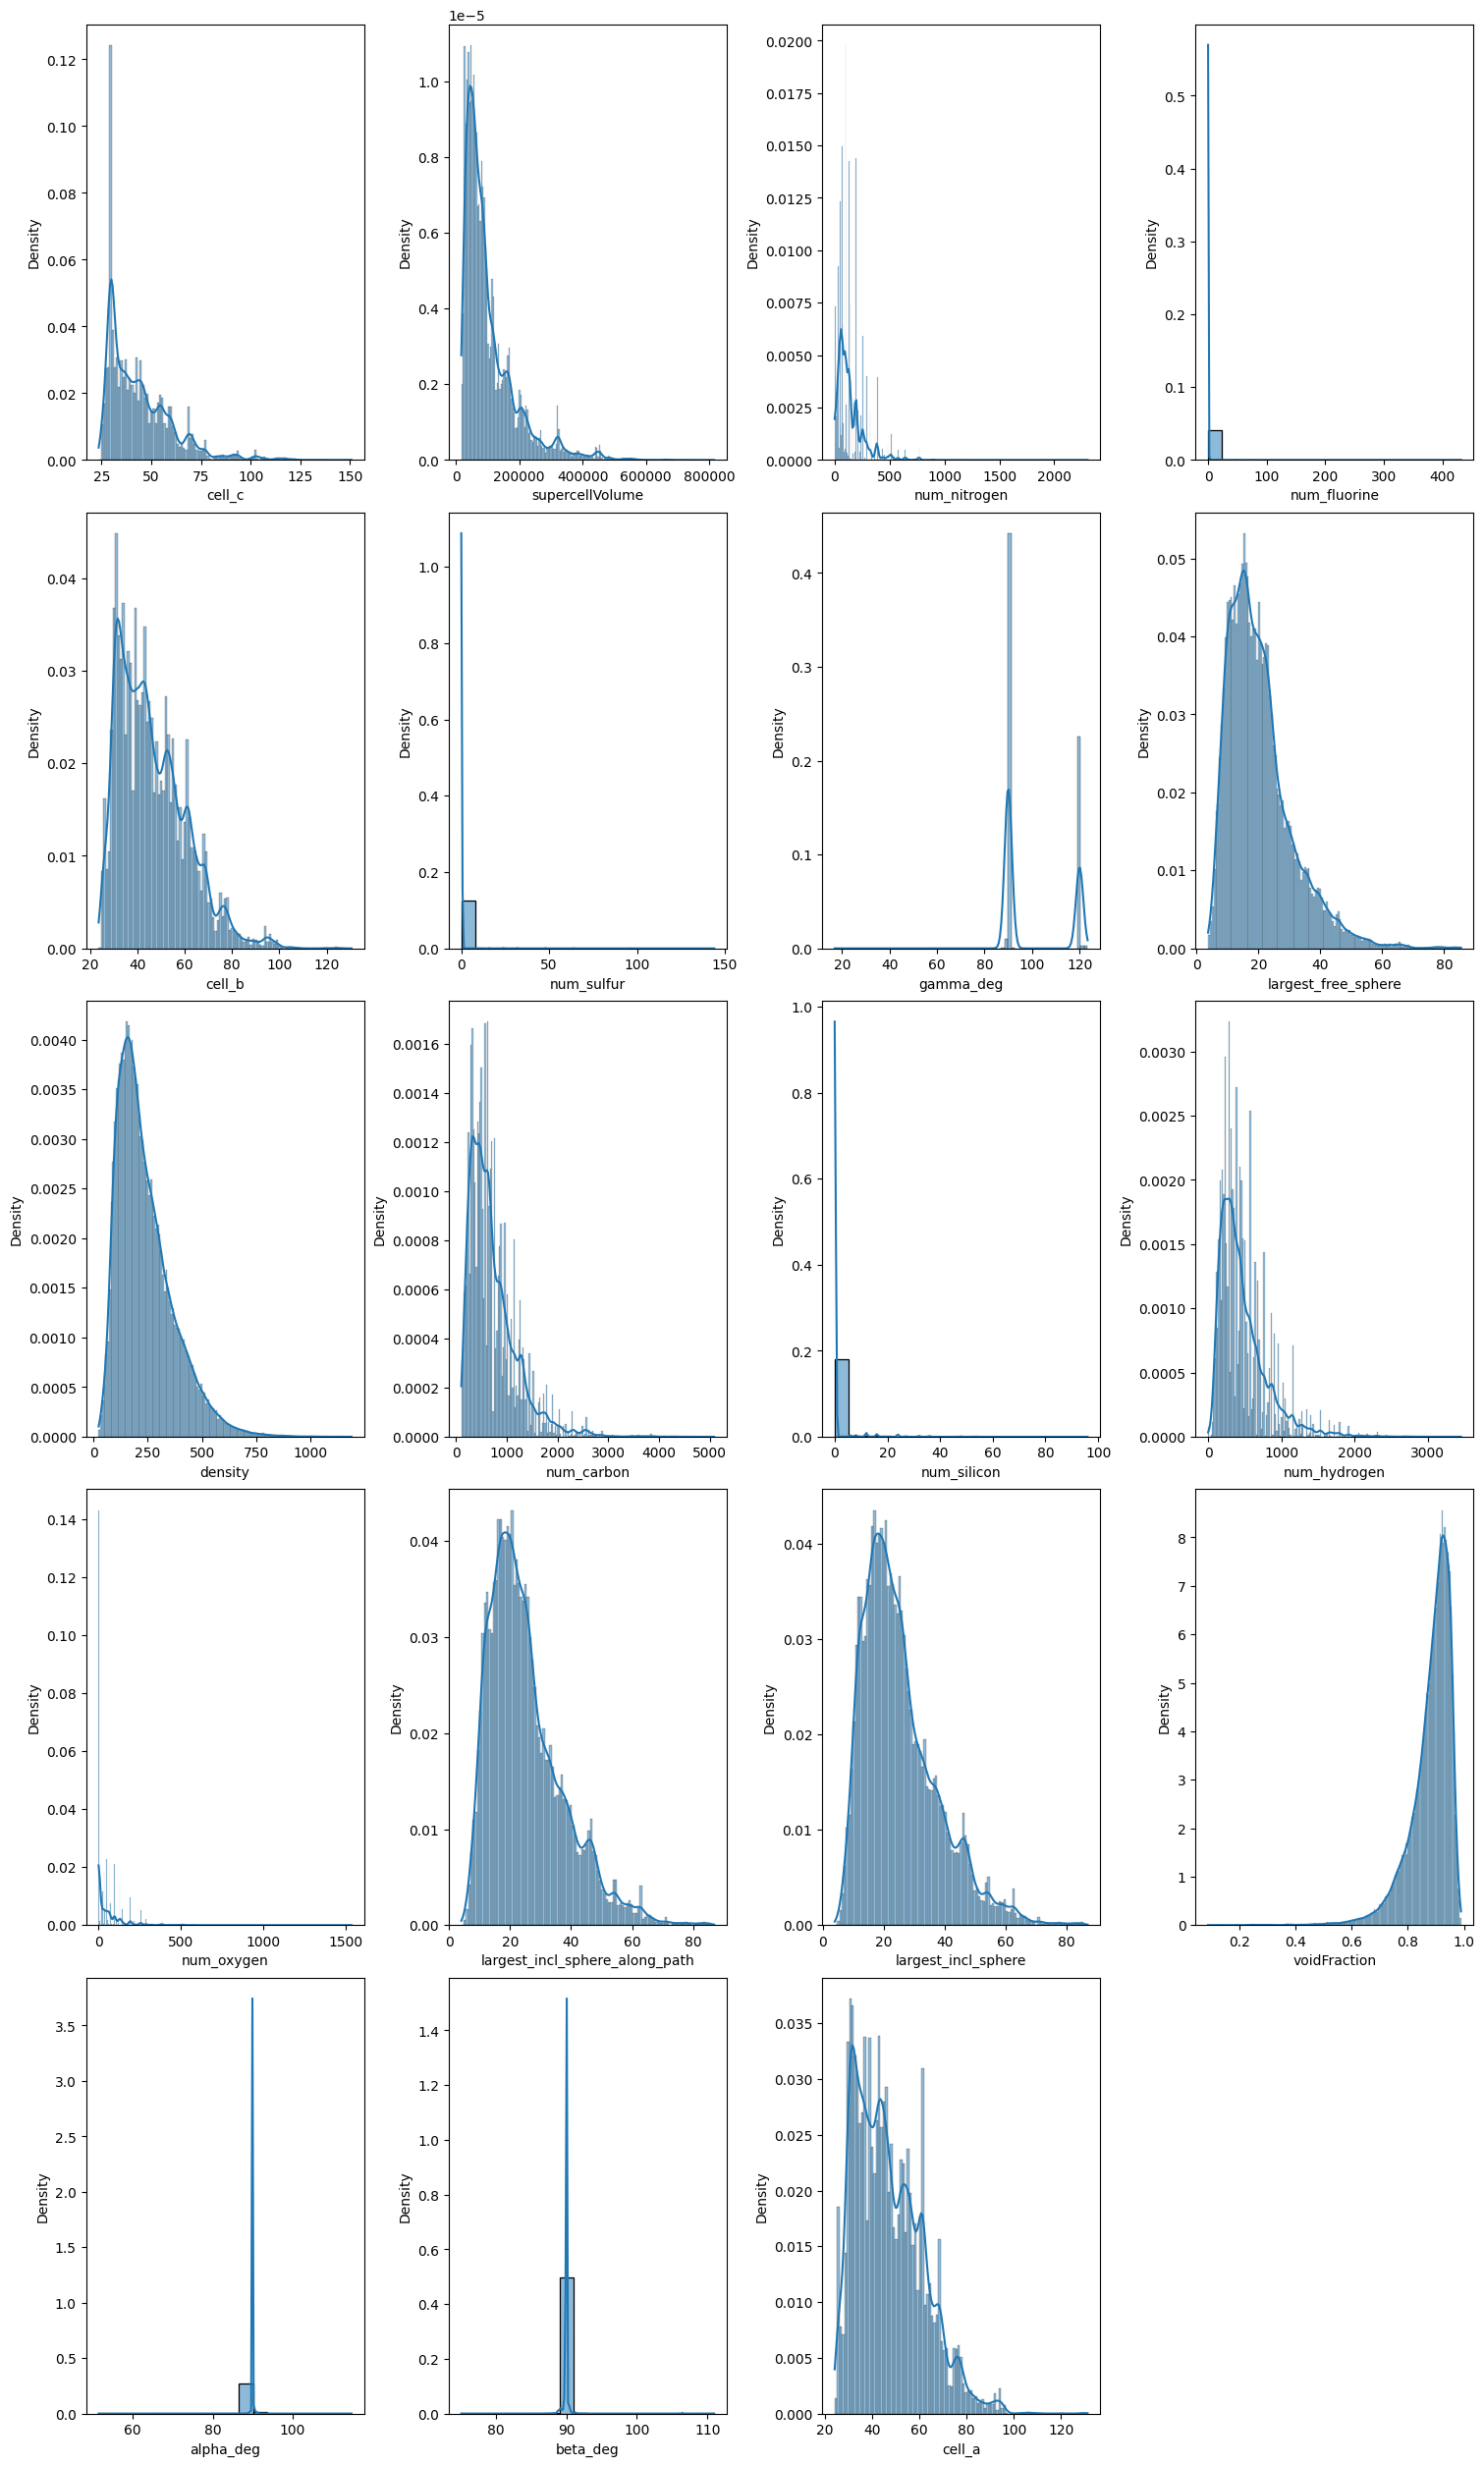

In [11]:
num_features = len(features)
num_cols = 4
num_rows = (num_features // num_cols) + int(num_features % num_cols != 0)

fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True
)

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, kde=True, stat="density", ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

> ✍️ **Are the numerical features normally distributed? If not, what distributions do they follow, and how might this impact model training?**

The numerical features exhibit varying distributions and do not conform to a standard normal distribution. Many of them appear to be either left- or right-skewed, and in some cases, such as `gamma_deg`, the data shows multiple modes. This indicates the need for standardization to ensure the features are on a consistent scale for model training.

### Correlation Analysis

Let's analyze the correlation between features and the target variable, as well as relationships among features, to gain insights. A correlation heatmap makes it easy to spot strong positive or negative correlations, helping identify dependencies and select useful features for the model.

> 💡 Use [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to calculate the correlation matrix, which returns the pairwise correlations between all features and the target variable. Then, use [`seaborn.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) to visualize this matrix.

<Axes: >

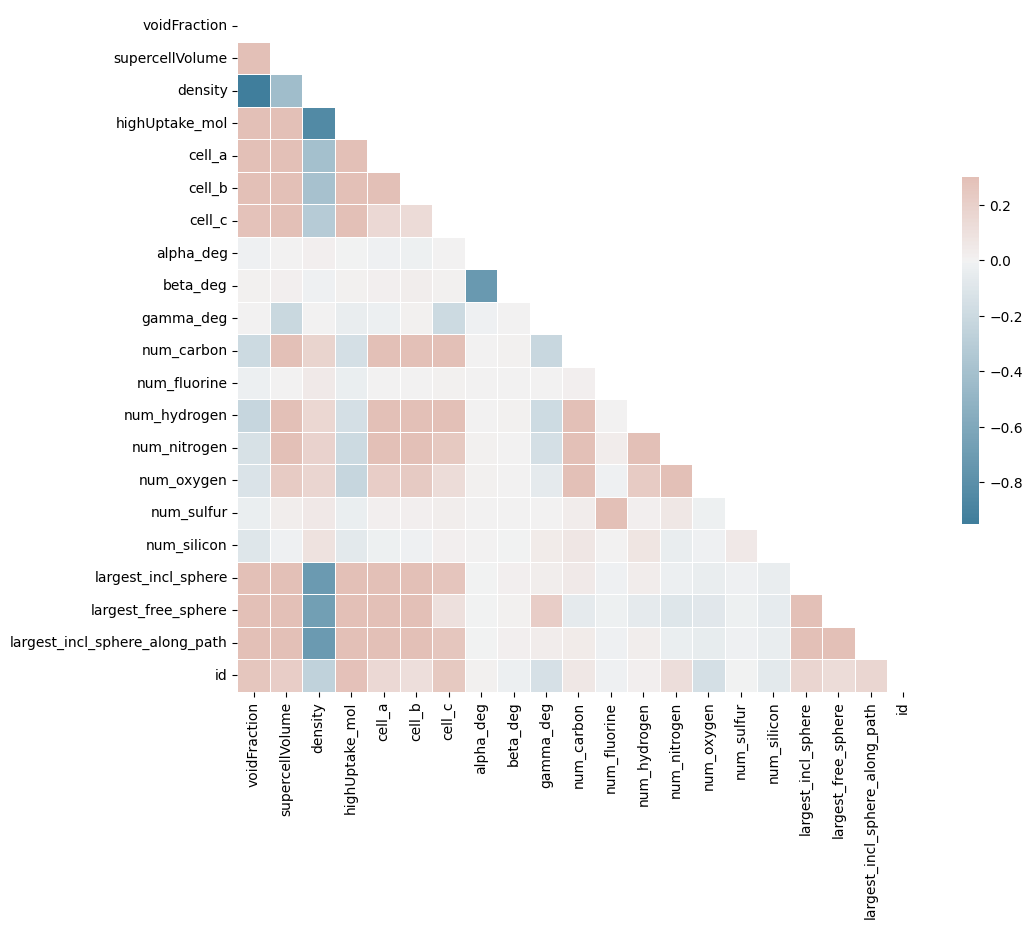

In [12]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)


> 💡 Use [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to calculate the correlation between features and the target variable. Then, apply [`pandas.Series.abs`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.abs.html) to get the absolute values of the correlations. This makes it easier to identify features with weak relationships to the target, which are likely to have minimal impact on your model. Sorting the correlations can further help pinpoint low-impact features that may be excluded to simplify the model.

In [13]:
df.corr()[target_variable].abs().drop(target_variable).sort_values()

alpha_deg                         0.003079
beta_deg                          0.007493
num_fluorine                      0.033902
num_sulfur                        0.035761
gamma_deg                         0.038372
num_silicon                       0.075446
num_hydrogen                      0.150592
num_carbon                        0.155605
num_nitrogen                      0.196907
num_oxygen                        0.226352
id                                0.291079
cell_c                            0.346337
cell_b                            0.411934
cell_a                            0.428908
supercellVolume                   0.511361
largest_free_sphere               0.702440
largest_incl_sphere_along_path    0.756197
largest_incl_sphere               0.759522
voidFraction                      0.803663
density                           0.845187
Name: highUptake_mol, dtype: float64

> ✍️ **Can some features be omitted? Are there high correlations between features? How can they be addressed?**

We observe high negative correlations between several features, which can lead to multicollinearity. This issue arises when features provide redundant or conflicting information, making it difficult for the model to estimate their individual contributions.

`alpha_deg` and `beta_deg` showcase near-zero correlation with the target and will therefore be omitted to streamline the model. `num_fluorine`, `num_sulfur`, `gamma_deg`, & `num_silicon` could also be considered for removal.

> 💡 Try [dimensionality reduction](https://scikit-learn.org/1.5/modules/unsupervised_reduction.html) (simpler one 😛), [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html), or [other methods](https://scikit-learn.org/1.5/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features) to remove highly correlated features. While performance improvement is not guaranteed, these techniques may result in faster model training times.

### Action Plan

> ✍️ **Formulate your action plan based on your findings so far**

- The dataset contains missing values that will require handling through imputation, row deletion, or oversampling, depending on their impact on the analysis.
- Features `alpha_deg` and `beta_deg` have near-zero correlation with the target, indicating they are not relevant to methane absorption and can be excluded to streamline the dataset.
- The numerical features show varying, often skewed distributions, suggesting the need for normalization. Techniques like [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) or [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) could be explored to bring features onto a consistent scale.
- To handle highly correlated features, we will experiment with [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis), which transforms correlated variables into uncorrelated components. PCA is a popular [dimensionality reduction method](https://scikit-learn.org/1.5/modules/unsupervised_reduction.html).

## ⛏️ Dataset Preprocessing

Preprocessing prepares our dataset by transforming raw data into a suitable format for modeling. [Consistent](https://scikit-learn.org/stable/common_pitfalls.html#inconsistent-preprocessing) preprocessing is crucial for optimal model performance. For a detailed overview of techniques, refer to the [scikit-learn guide](https://scikit-learn.org/1.5/modules/preprocessing.html).

> 💡 To clean the dataset, use [`pandas.DataFrame.dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to remove rows with missing values. Additionally, drop any irrelevant features using [`pandas.DataFrame.drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html). 
> 
> **Standardization and dimensionality reduction should be incorporated into the actual ML pipeline!**

In [14]:
df.dropna(inplace=True)
df.drop(["alpha_deg", "beta_deg"], axis=1, inplace=True)

## 🤖 Model Selection & Testing

> 💡 [Choose at least 3 models](https://scikit-learn.org/stable/machine_learning_map.html) to test out, ensuring they represent a variety of approaches (e.g., linear, tree-based, and support vector methods). Ensure estimators use the `random_state` parameter where appropriate to control randomness and ensure reproducibility.
> 
> Use [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html) to combine steps like preprocessing and model training into one workflow. Creating a function to build your pipeline makes it easier to try different configurations.

In [15]:
features = list(set(df.columns).difference([target_variable, "id"]))

(1.0, 17.0)

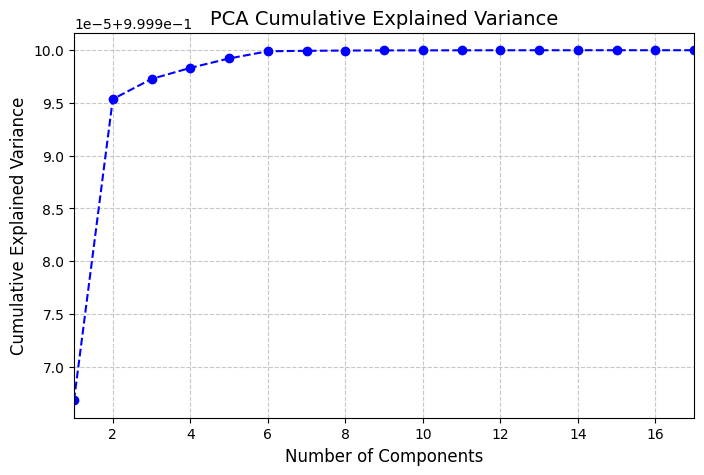

In [16]:
pca = PCA(random_state=RANDOM_SEED)
pca.fit(df[features])

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(
    np.linspace(1, len(cumulative_variance), len(cumulative_variance)),
    cumulative_variance,
    marker="o",
    linestyle="--",
    color="b",
    label="Cumulative Explained Variance",
)
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.title("PCA Cumulative Explained Variance", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(1, len(cumulative_variance))

The plot indicates that 6 principal components capture 99.999% of the variance in the dataset, making this our chosen number of components moving forward.

In [17]:
class ModelChoice(IntEnum):
    LINEAR_REGRESSION = auto()
    RANDOM_FOREST = auto()
    SVM = auto()


def create_pipeline(
    model_choice: ModelChoice,
    n_components: int | None = None,
    random_state: int = RANDOM_SEED,
) -> Pipeline:
    steps = [("scaler", StandardScaler())]

    if n_components is not None:
        steps.append(("pca", PCA(n_components=n_components, random_state=random_state)))

    if model_choice == ModelChoice.LINEAR_REGRESSION:
        steps.append(("model", LinearRegression()))
    elif model_choice == ModelChoice.RANDOM_FOREST:
        steps.append(("model", RandomForestRegressor(random_state=random_state)))
    elif model_choice == ModelChoice.SVM:
        steps.append(("model", SVR()))
    else:
        raise ValueError("Invalid model choice")

    return Pipeline(steps=steps)

### Evaluating our Model Candidates

To assess our model candidates, we'll employ (5-fold) [cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html). This process involves splitting the dataset into five parts (or *"folds"*), training the model on four of them, and testing it on the remaining one. This process will be repeated five times, each time with a different fold as the test set, providing a more reliable estimate of model performance. 

For each model in our pool, we will evaluate its performance using [multiple regression metrics](https://scikit-learn.org/1.5/modules/model_evaluation.html#regression-metrics).

>💡 Use [`sklearn.model_selection.cross_validate`](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) with multiple scoring metrics to [evaluate model performance across various dimensions](https://scikit-learn.org/1.5/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation). `cross_validate` returns a dictionary that includes a `fit_time` entry; you can calculate the average fit time from this data.

In [18]:
metrics = ["neg_mean_squared_error", "neg_mean_absolute_percentage_error", "r2"]

results = {}
for model_choice in tqdm(ModelChoice):
    for n_components in tqdm([None, 6], leave=False):
        name = model_choice.name
        if n_components is not None:
            name += f"(with PCA[{n_components}])"

        results[name] = {}
        pipeline = create_pipeline(
            model_choice, n_components=n_components, random_state=RANDOM_SEED
        )

        result = cross_validate(
            pipeline, df[features], df[target_variable], cv=5, scoring=metrics
        )
        for metric in metrics:
            values = result[f"test_{metric}"]
            mean = values.mean()
            std = values.std()

            results[name][metric] = f"{mean * 100:.3f} +/- {std * 100:.3f}"

        avg_fit_time = result["fit_time"].mean()
        results[name]["Average Fit Time (s)"] = f"{avg_fit_time:.3f}"

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
pd.DataFrame(results).T

,neg_mean_squared_error,neg_mean_absolute_percentage_error,r2,Average Fit Time (s)
LINEAR_REGRESSION,-1999.988 +/- 595.370,-9.039 +/- 1.294,80.894 +/- 2.711,0.046
LINEAR_REGRESSION(with PCA[6]),-2256.886 +/- 630.153,-10.140 +/- 2.029,78.442 +/- 2.446,0.037
RANDOM_FOREST,-94.863 +/- 23.551,-2.469 +/- 0.593,99.045 +/- 0.286,52.481
RANDOM_FOREST(with PCA[6]),-702.804 +/- 204.209,-5.700 +/- 1.128,93.193 +/- 1.370,29.431
SVM,-376.740 +/- 201.303,-3.450 +/- 1.253,96.583 +/- 1.319,59.935
SVM(with PCA[6]),-1088.570 +/- 314.678,-7.362 +/- 1.419,89.606 +/- 1.466,61.677


> ✍️ **Why were these evaluation metrics chosen? How does training time compare? How do the metrics vary across models, and what do the results reveal about each model's performance? Use these insights to select the best-performing model.**

$R^2$, Mean Squared Error (MSE), and Mean Absolute Percentage Error (MAPE) are commonly used regression metrics and provide complementary insights into model performance:

- **$R^2$** measures the proportion of variance in the target variable that can be explained by the model, helping to evaluate how well the model fits the data.
- **MSE** penalizes larger errors more heavily by squaring the differences, making it useful for identifying models that consistently make large errors.
- **MAPE** focuses on the relative error, making it robust to global scaling of the target variable and useful for evaluating the model’s performance in terms of percentage error, especially in scenarios where relative differences are more important than absolute ones.

Our results show that **Random Forest (without PCA)** is the best choice, as it performs well across all metrics. While it takes more time to run, it outperforms the other models by a large margin. Using PCA made the performance worse and increased the fit time for all models, so it’s not needed for this task.

### Making Predictions and Ranking Materials

Using your best model, predict the methane adsorption capacity of the materials in the test set. Rank the materials by their methane absorption capacity and identify the top performer.

In [20]:
pipeline = create_pipeline(
    ModelChoice.RANDOM_FOREST, n_components=None, random_state=RANDOM_SEED
)
pipeline.fit(df[features], df[target_variable])

df_test = pd.read_csv("./data/test.csv")
y_pred = pipeline.predict(df_test[features])

pd.DataFrame({"id": df_test["id"], target_variable: y_pred}).sort_values(
    target_variable, ascending=False
)

,id,highUptake_mol
0,69403,133.011265
4,66217,125.698243
2,69353,122.439984
3,40368,114.963420
5,40356,113.879060
...,...,...
58,45838,20.383326
39,13337,19.564907
63,28266,18.424387
68,37107,15.416354


## 📜 Creating the Submission File

1. **Prepare the Submission**: Keep only the `id` column and the predicted `highUptake_mol` column in your DataFrame.
2. **Save as CSV**: Export the DataFrame as a CSV file, ensuring to exclude the index.

> 💡 Use [`pandas.DataFrame.to_csv`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html) to save the DataFrame.

In [21]:
submission = pd.DataFrame({"id": df_test["id"], target_variable: y_pred})

submission.to_csv("submission.csv", index=False)